# Running Ensemble Inference in Earth-2 MIP

The following notebook demostrates how to use Earth-2 MIP's config schema and builtin inference workflows to perform ensemmble inference of the FourCastNetv2 small (FCNv2-sm) weather model with an intial state pulled from the Climate Data Store (CDS) and perturbed with random noise. The ensemble output will then be loaded into an Xarray Dataset and some sample data analysis is provided.

In summary this notebook will cover the following topics:

- Configuring and setting up FCNv2 model registry
- An ensemble configuration file
- Running ensemble inference in Earth-2 MIP to produce an xarray DataSet
- Post processing results

## Set Up

Starting off with imports, hopefully you have already installed Earth-2 MIP from this repository. There are a few additional packages needed. Lets install these first.

In [1]:
%%capture
!pip install cartopy

In [2]:
# For running inference we dont need much
import os, json, logging
import xarray

Prior to importing Earth-2 MIP, its critical we set up a few enviroment variables which will help Earth-2 MIP get configured correctly under the hood. There are a number of different global configuration options, the ones will will set here are:

- `WORLD_SIZE`: Tells Earth-2 MIP (which uses Modulus under the hood) the number of GPUs present
- `MODEL_REGISTRY`: This variable tells Earth-2 MIP where look for a model registery

*Key Concept*: A model registry is a folder that Earth-2 MIP will explore to find model checkpoints to load. A folder containing the required fileds is referred to as a "model package". Model packages typically consist of a few files including:
- `weights.tar`: the Pytorch model checkpoint to load
- `metadata.json`: a JSON file that contains meta info regarding various details for using the model
- `config.json`: constains parameters needed to instantiate the model object in python
- `global_means.npy`: A numpy array containing the mean values used for normalization of data in the model
- `global_std.npy`: A numpy array containing the standard deviation values used for normalization of data in the model

In [3]:
# Set number of GPUs to use to 1
os.environ['WORLD_SIZE'] = '1'
# Set model registry as a local folder
model_registry = os.path.join(os.path.dirname(os.path.realpath(os. getcwd())), "models")
os.makedirs(model_registry, exist_ok=True)
os.environ['MODEL_REGISTRY'] = model_registry

# With the enviroment variables set now we import Earth-2 MIP
from earth2mip import inference_ensemble

The cell above created a model registry folder for us, but if this is your first notebook its likely empty. Lets fix that. As previously metioned we will be using the FCNv2-sm weather model with the checkpoint provided on the Nvidia Modulus model registry. The model is shipped via a zip folder containing the required checkpoint files discussed above.

In [4]:
import subprocess
if not os.path.isdir(os.path.join(model_registry, 'fcnv2_sm')):
    print("Downloading model checkpoint, this may take a bit")
    subprocess.run(['wget', '-nc', '-P', f'{model_registry}', 'https://api.ngc.nvidia.com/v2/models/nvidia/modulus/modulus_fcnv2_sm/versions/v0.2/files/fcnv2_sm.zip'], stdout=subprocess.DEVNULL, stderr=subprocess.STDOUT)
    subprocess.run(['unzip', '-u', f'{model_registry}/fcnv2_sm.zip', '-d', f'{model_registry}'])
    subprocess.run(['rm', f'{model_registry}/fcnv2_sm.zip'])

The final setup step is to set up your CDS API key so we can access ERA5 data to act as an initial state. Earth-2 MIP supports a number of different initial state data sources that are supported including HDF5, CDS, GFS, etc. The CDS initial state provides a convenient way to access a limited amount of historical weather data. Its recommended for accessing an initial state, but larger data requirements should use locally stored weather datasets.

Enter your CDS API uid and key below (found under your profile page). If you don't a CDS API key, find out more here.
- [https://cds.climate.copernicus.eu/cdsapp#!/home](https://cds.climate.copernicus.eu/cdsapp#!/home)
- [https://cds.climate.copernicus.eu/api-how-to](https://cds.climate.copernicus.eu/api-how-to)

In [5]:
# Run this cell and input your credentials in the notebook
cds_api = os.path.join(os.path.expanduser("~"), '.cdsapirc')
if not os.path.exists(cds_api):
    uid = input("Enter in CDS UID (e.g. 654321)")
    key = input("Enter your CDS API key (e.g. 12345678-1234-1234-1234-123456123456)")
    # Write to config file for CDS library
    with open(cds_api, 'w') as f:
        f.write('url: https://cds.climate.copernicus.eu/api/v2\n')
        f.write(f'key: {uid}:{key}\n')

## Running Inference

To run inference we will use the `earth2mip/ensemble_inference.py` part of Earth-2 MIP. When this Python file, we provide either a config JSON file or a JSON serialized string for it to parse. This config contains the information regarding how the model should run inference. The schema of this can be found in `earth2mip/schema/EnsembleRun`.

Since we are working in a notebook, lets create this config Pythonically. There are quite a few parameters that can be used, but lets focus in on a few key ones:

- `ensemble_members`: Number ensemble members in the forecast
- `noise_amplitude`: The amplitude of the noise pertibation method (we find that a good value to start with is `0.05`, feel free to experiment)
- `simulation_length`: Number of (6h) time-steps to predict
- `weather_event`: This defines the weather event as a combination of an initial time and a domain. 
    * The domain property defines the IO, ,by telling Earth-2 MIP for what regions (if `window`) or points (if `multipoint`) data should be stored. It also defines the `channels` and the diagnostic.  In this example the global field is recorded for the `t2m` and `u10m` channels. You can further also explore the `diagnostics` options in Diagnostics class in earth2mip/Diagnostics.py.
- `output_path`: The output location of the ensemble prediction netCDF file
- `weather_model`: The model ID to run. This MUST match the name of the model registry folder with your checkpoint files. So for this example its `fcnv2_sm`.

Note: While in later notebooks we will demonstrate more Pythonic methods to interact with Earth-2 MIP's APIs, the built in inference workflows provide a high-degree of control with little to no programming. 

In [6]:
config =  {
    "ensemble_members": 4,
    "noise_amplitude": 0.05,
    "simulation_length": 80,
    "weather_event": {
        "properties": {
            "name": "Globe",
            "start_time": "2022-07-01 00:00:00",
            "initial_condition_source": "cds"
        },
        "domains": [
            {
                "name": "global",
                "type": "Window",
                "diagnostics": [
                    {
                        "type": "raw",
                        "channels": [
                            "t2m",
                            "u100m"
                        ]
                    }
                ]
            }
        ]
    },
    "output_path": "../outputs/04_demo_notebook",
    "output_frequency": 1,
    "weather_model": "fcnv2_sm",
    "seed": 12345,
    "use_cuda_graphs": False,
    "ensemble_batch_size": 1,
    "autocast_fp16": False,
    "perturbation_strategy": "correlated",
    "noise_reddening": 2.0
}

Now we run the `main()` function in `earth2mip.inference_ensemble` providing our config object which will run inference with the following steps:

1. Instantiate and load the FCNv2 small weather model onto the device
2. Download the initial state data needed from CDS using your saved API key
3. Perturb the initial state based on the parameters in the config and run a forecast predicton
4. Save output Xarray dataset to NetCDF file located in `../outputs/01_ensemble_notebook`

(the process may take a while!)

In [7]:
# Option 1: Use config file and CLI (use this outside a notebook)
# with open('./01_config.json', 'w') as f:
#     json.dump(config, f)
# ! python3 -m earth2mip.inference_ensemble 01_config.json

# Option 2: Feed in JSON string directly into main function
from earth2mip.inference_ensemble import main
config_str = json.dumps(config)
main(config_str)

INFO:root:Earth-2 MIP config loaded weather_model='fcnv2_sm' simulation_length=80 perturbation_strategy=<PerturbationStrategy.correlated: 'correlated'> perturbation_channels=None noise_reddening=2.0 noise_amplitude=0.05 output_frequency=1 output_grid=None ensemble_members=4 seed=12345 ensemble_batch_size=1 forecast_name=None weather_event=WeatherEvent(properties=WeatherEventProperties(name='Globe', start_time=datetime.datetime(2022, 7, 1, 0, 0), initial_condition_source=<InitialConditionSource.cds: 'cds'>, netcdf='', restart=''), domains=[Window(type='Window', name='global', lat_min=-90, lat_max=90, lon_min=0, lon_max=360, diagnostics=[Diagnostic(type='raw', function='', channels=['t2m', 'u100m'], nbins=10)])]) output_dir=None output_path='../outputs/04_demo_notebook' restart_frequency=None grf_noise_alpha=2.0 grf_noise_sigma=5.0 grf_noise_tau=2.0
INFO:root:Loading model onto device cuda:0
INFO:root:Constructing initializer data source
INFO:root:Running inference
INFO:earth2mip.initial

When the inference is complete we can examine the output in `../ouputs/01_ensemble_notebook/ensemble_out_0.nc`. 

Note: if the inference is distributed across N GPUs there will be `ensemble_out_0.nc`,`ensemble_out_1.nc`, ... `ensemble_out_N-1.nc` output files. 
In this case a function like this could concat the files to a single xarray DataArray:

```python
def _open(f, domain, time, chunks={"time": 1}):
    root = xarray.open_dataset(f, decode_times=False)
    ds = xarray.open_dataset(f, chunks=chunks, group=domain)
    ds.attrs = root.attrs
    return ds.assign_coords(time=lead_time)


def open_ensemble(path, domain, time):
    path = pathlib.Path(path)
    ensemble_files = list(path.glob("ensemble_out_*.nc"))
    return xarray.concat(
        [_open(f, group, time) for f in ensemble_files], dim="ensemble"
    )
```

(TODO: Move this into a parallel inference notebook!)

But with our single NetCDF file we can load it into a [Xarray Dataset](https://docs.xarray.dev/en/stable/generated/xarray.Dataset.html) with just a few lines of code.

In [8]:
def open_ensemble(f, domain, chunks={"time": 1}):
    time = xarray.open_dataset(f).time
    root = xarray.open_dataset(f, decode_times=False)
    ds = xarray.open_dataset(f, chunks=chunks, group=domain)
    ds.attrs = root.attrs
    return ds.assign_coords(time=time)

output_path = config["output_path"]
domains = config["weather_event"]["domains"][0]["name"]
ensemble_members = config["ensemble_members"]
ds = open_ensemble(os.path.join(output_path, "ensemble_out_0.nc"), domains)
ds

<xarray.Dataset>
Dimensions:  (lat: 721, lon: 1440, ensemble: 4, time: 81)
Coordinates:
  * lat      (lat) float32 90.0 89.75 89.5 89.25 ... -89.25 -89.5 -89.75 -90.0
  * lon      (lon) float32 0.0 0.25 0.5 0.75 1.0 ... 359.0 359.2 359.5 359.8
  * time     (time) datetime64[ns] 2022-07-01 2022-07-01T06:00:00 ... 2022-07-21
Dimensions without coordinates: ensemble
Data variables:
    imin     int64 ...
    imax     int64 ...
    jmin     int64 ...
    jmax     int64 ...
    t2m      (ensemble, time, lat, lon) float64 dask.array<chunksize=(4, 1, 721, 1440), meta=np.ndarray>
    u100m    (ensemble, time, lat, lon) float64 dask.array<chunksize=(4, 1, 721, 1440), meta=np.ndarray>
Attributes:
    model:          fcnv2_sm
    config:         {"weather_model": "fcnv2_sm", "simulation_length": 80, "p...
    weather_event:  {"properties": {"name": "Globe", "start_time": "2022-07-0...
    date_created:   2023-11-08T14:22:29.852939
    history:        /usr/local/lib/python3.10/dist-packages/ipykernel_launche...
    institution:    NVIDIA
    Conventions:    CF-1.10

## Post Processing

With inference complete, now the fun part: post processing and analysis!
You can manipulate the data to your hearts content now that its in an Xarray Dataset.
Here we will demonstrate some common plotting / analysis workflows one may be interested.
Lets start off with importing all our post processing packages.

In [9]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from io import StringIO
from matplotlib.colors import TwoSlopeNorm
from datetime import datetime, timedelta

countries = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_0_countries',
    scale='50m',
    facecolor='none',
    edgecolor='black'
)

Up first, we can plot a time series of the value of a variable (or statistics of that variable) at a given location (lat/lon coord). In this case lets look at the results predicted over New York. 

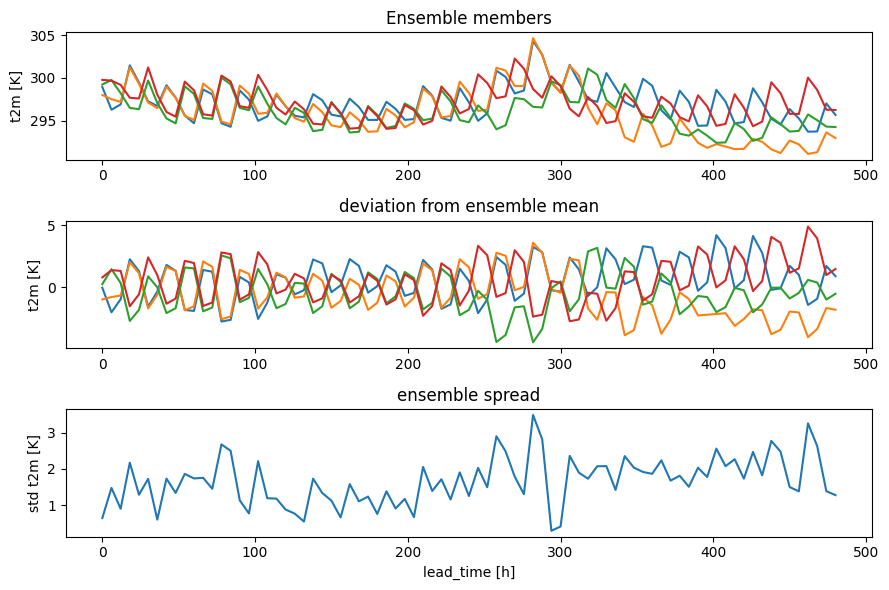

In [13]:

lead_time = np.array((pd.to_datetime(ds.time) - pd.to_datetime(ds.time)[0]).total_seconds()/ 3600)
nyc_lat = 40
nyc_lon = 360-74
NYC = ds.sel(lon = nyc_lon, lat = nyc_lat)
fig = plt.figure(figsize=(9, 6))
ax = fig.add_subplot(311)
ax.set_title('Ensemble members')
ax.plot(lead_time, NYC.t2m.T)
ax.set_ylabel('t2m [K]')

ax = fig.add_subplot(312)
ax.set_title('deviation from ensemble mean')
ax.plot(lead_time, NYC.t2m.T-NYC.t2m.mean("ensemble"))
ax.set_ylabel('t2m [K]')

ax = fig.add_subplot(313)
ax.set_title('ensemble spread')
ax.plot(lead_time, NYC.t2m.std("ensemble"))
ax.set_xlabel('lead_time [h]')
ax.set_ylabel('std t2m [K]')
plt.tight_layout()

Next, lets plot some fields of surface temperature. Since we have an ensemble of predictions, lets display the first ensemble member, which is deterministic member, and also the last ensemble member and the ensemmble standard deviation. One or both of the perturbed members may look a little noisy, thats because our noise amplitude is maybe too high. Try lowering the amplitude in the config or changing pertibation type to see what happens.

In [ ]:

fig = plt.figure(figsize=(15, 10))
plt.rcParams['figure.dpi'] = 100
proj = ccrs.NearsidePerspective(central_longitude=nyc_lon, central_latitude=nyc_lat)

data = ds.t2m[0,-1,:,:]
norm = TwoSlopeNorm(vmin=220, vcenter=290, vmax=320)
ax = fig.add_subplot(131, projection=proj)
ax.set_title('First ensemble member t2m (K)')
img = ax.pcolormesh(ds.lon, ds.lat, data, transform=ccrs.PlateCarree(), norm=norm, cmap="seismic")
ax.coastlines(linewidth=1)
ax.add_feature(countries, edgecolor='black', linewidth=0.25)
plt.colorbar(img, ax=ax, shrink=0.40, norm=mcolors.CenteredNorm(vcenter=0))
gl = ax.gridlines(draw_labels=True, linestyle='--')

data = ds.t2m[-1,-1,:,:]
norm = TwoSlopeNorm(vmin=220, vcenter=290, vmax=320)
ax = fig.add_subplot(132, projection=proj)
plt.rcParams['figure.dpi'] = 100
proj = ccrs.NearsidePerspective(central_longitude=nyc_lon, central_latitude=nyc_lat)
ax.set_title('Last ensemble member t2m (K)')
img = ax.pcolormesh(ds.lon, ds.lat, data, transform=ccrs.PlateCarree(), norm=norm, cmap="seismic")
ax.coastlines(linewidth=1)
ax.add_feature(countries, edgecolor='black', linewidth=0.25)
plt.colorbar(img, ax=ax, shrink=0.40, norm=mcolors.CenteredNorm(vcenter=0))
gl = ax.gridlines(draw_labels=True, linestyle='--')

ds_ensemble_std = ds.std(dim = "ensemble")
data = ds_ensemble_std.t2m[-1,:,:]
# norm = TwoSlopeNorm(vmin=data.min().values, vcenter=5, vmax=data.max().values)
proj = ccrs.NearsidePerspective(central_longitude=nyc_lon, central_latitude=nyc_lat)
ax = fig.add_subplot(133, projection=proj)
ax.set_title('ensemble std  t2m (K)')
img = ax.pcolormesh(ds.lon, ds.lat, data, transform=ccrs.PlateCarree(), cmap="seismic")
ax.coastlines(linewidth=1)
ax.add_feature(countries, edgecolor='black', linewidth=0.25)
plt.colorbar(img, ax=ax, shrink=0.40, norm=mcolors.CenteredNorm(vcenter=0))
gl = ax.gridlines(draw_labels=True, linestyle='--')

We can also show a map of the ensemble mean of the 10 meter zonal winds (using some Nvidia coloring!) 

In [ ]:
def Nvidia_cmap():
    colors = ['#8946ff', '#ffffff', '#00ff00']
    cmap = mcolors.LinearSegmentedColormap.from_list("custom_cmap", colors)
    return cmap

ds_ensemble_mean = ds.mean(dim = "ensemble")
data = ds_ensemble_mean.u10m[-1,:,:]
fig = plt.figure(figsize=(9, 6))
plt.rcParams['figure.dpi'] = 100
proj = ccrs.NearsidePerspective(central_longitude=nyc_lon, central_latitude=nyc_lat)

ax = fig.add_subplot(111, projection=proj)
ax.set_title('ens. mean 10 meter zonal wind [m/s]')
img = ax.pcolormesh(ds.lon, ds.lat, data, transform=ccrs.PlateCarree(), cmap = Nvidia_cmap(), vmin=-20, vmax=20)
ax.coastlines(linewidth=1)
ax.add_feature(countries, edgecolor='black', linewidth=0.25)
plt.colorbar(img, ax=ax, shrink=0.40, norm=mcolors.CenteredNorm(vcenter=0))
gl = ax.gridlines(draw_labels=True, linestyle='--')

Finally lets compute the latitude-weighted global averages and plot time series of ensemble standard deviation

In [ ]:
def global_average(ds):
    cos_lat = np.cos(np.deg2rad(ds.lat))
    return ds.weighted(cos_lat).mean(["lat", "lon"])

ds_ensemble_std = global_average(ds.std(dim = "ensemble"))
plt.figure()
plt.plot(lead_time, ds_ensemble_std.u10m)
plt.xlabel('lead time [k]')
plt.ylabel('u10m std [m/s]')

And that completes the introductory notebook into running ensemble weather predictions with AI. In the next notebook, we will look at running different models using more Pythonic APIs and plotting geopotential fields. 